In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyts.datasets import make_cylinder_bell_funnel

In [11]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [12]:
random_state = 0

# IMPORT DATASET

In [13]:
dataset_name = "cbf"

In [14]:
X_all, y_all = make_cylinder_bell_funnel(n_samples = 600, random_state = random_state)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

In [15]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (600, 128, 1)
y SHAPE:  (600,)

CLASSES BALANCE
0 :  0.33
1 :  0.33
2 :  0.33


## DATASET SPLIT

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (268, 128, 1)
BLACKBOX VALIDATION SET:  (68, 128, 1)
BLACKBOX TEST SET:  (84, 128, 1)
EXPLANATION TRAINING SET:  (115, 128, 1)
EXPLANATION VALIDATION SET:  (29, 128, 1)
EXPLANATION TEST SET:  (36, 128, 1)


In [18]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  128
N. LABELS:  3


# BLACKBOX MODEL

In [19]:
from joblib import load
import keras
"""import importlib
importlib.reload(blackboxes)"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import time
import blackboxes
from blackboxes import *

## resnet

In [20]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_resnet_20191106_145242_best_weights_+1.00_.hdf5")
resnet = blackbox

## simple CNN

In [21]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/cbf_blackbox_simpleCNN_20191106_145515_best_weights_+1.00_.hdf5")
simplecnn = blackbox

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [23]:
knn = load(parentdir + "/blackbox_checkpoints/cbf_blackbox_knn_20191106_145654.joblib")

# AUTOENCODER

In [24]:
"""import importlib
importlib.reload(autoencoders)"""
import autoencoders
from autoencoders import *

## Standard

In [25]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144056_best_weights_+1.0504_.hdf5")
ae = autoencoder

## VARIATIONAL

In [26]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_144909_best_weights_+136.8745_.hdf5")
vae = autoencoder

## DISCRIMINATIVE STANDARD

In [27]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(verbose = False, **params)
encoder, decoder, discriminator, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_150722_best_weights_+1.239848_.hdf5")
dae = autoencoder

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## DISCRIMINATIVE VARIATIONAL

In [28]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 2,
          "encoder_latent_layer_type": "variational",
          "encoder_args": {"filters":[2, 4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"elu", 
                            "pooling":[1,1,1,1,1,1,1,1]},
          "discriminator_args": {"units": [100,100],
                                 "activation": "relu"},
          "n_blocks_discriminator": 2
         }

aut = DiscriminativeAutoencoder(verbose = False, **params)
encoder, decoder, discriminator, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/cbf_autoencoder_20191106_153613_best_weights_+1.179660_.hdf5")
dvae = autoencoder

# NEIGHBORHOOD GENERATION

In [31]:
import agnosticlocalexplainer
from agnosticlocalexplainer import *
import importlib
importlib.reload(agnosticlocalexplainer)

<module 'agnosticlocalexplainer' from '/Users/francesco/github/TS_AgnosticLocalExplainer/agnosticlocalexplainer.py'>

In [32]:
autoencoder = vae

In [33]:
index_to_explain = 1

## RESNET

In [34]:
blackbox = resnet

In [35]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [36]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3,
                                  labels = ["cylinder", "bell", "funnel"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  cylinder (0)


In [37]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.558494	0.00784354	0.993303
2  	103   	0.693481	0.00708788	0.993306
3  	105   	0.777876	0.0102719 	0.993306
4  	108   	0.874363	0.00703221	0.993306
5  	104   	0.868316	0.00670185	0.993307
6  	112   	0.896679	0.0501654 	0.993307
7  	105   	0.895915	0.00953478	0.993307
8  	103   	0.878212	0.00692983	0.993307
9  	111   	0.828511	0.00851787	0.993307
10 	103   	0.898501	0.00726897	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.555164	0.494796	0.993083
2  	108   	0.616365	0.493904	0.993083
3  	113   	0.727497	0.49128 	0.993083
4  	110   	0.785124	0.494795	0.993304
5  	103   	0.883282	0.492306	0.993299
6  	105   	0.87225 	0.496858	0.993299
7  	113   	0.909525	0.488356	0.993307
8  	102   	0.895752	0.496541	0.993304
9  	103   	0.881052	0.490587	0.993305
10 	111   	0.90473 	0.495855	0.993305
synthetic neighborhood class counts {0: 216, 1: 91, 2: 216}


In [38]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [39]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


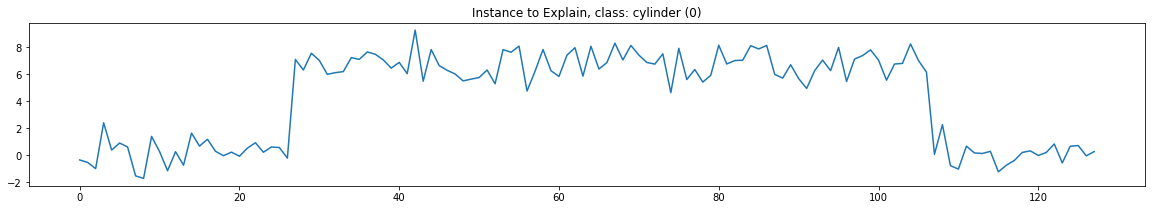

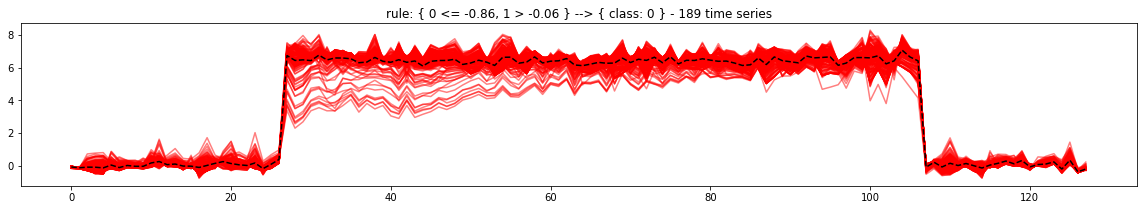

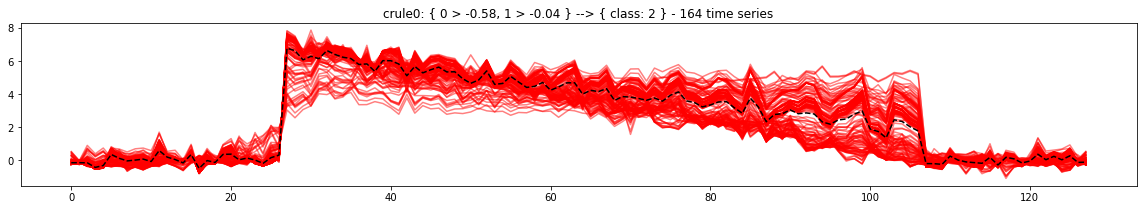

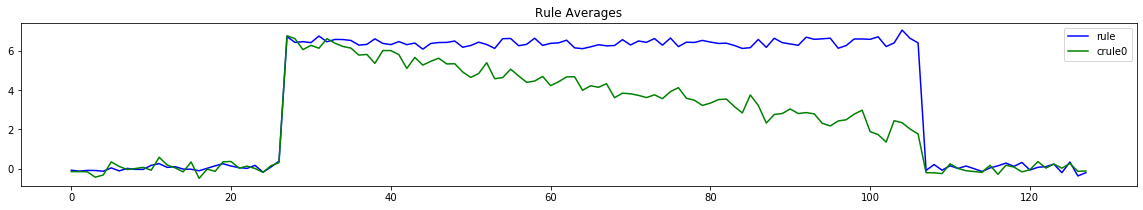

rule


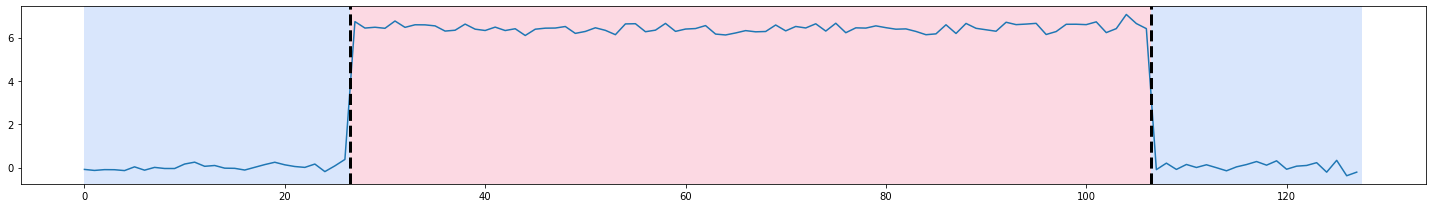

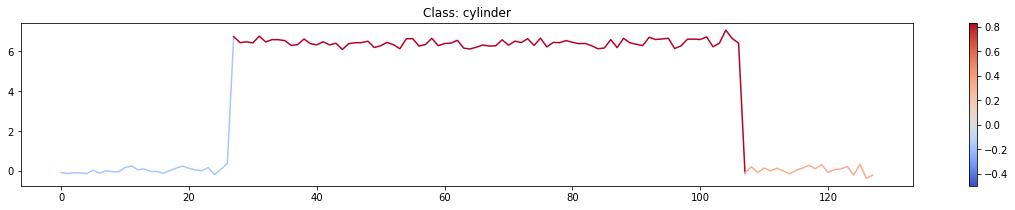

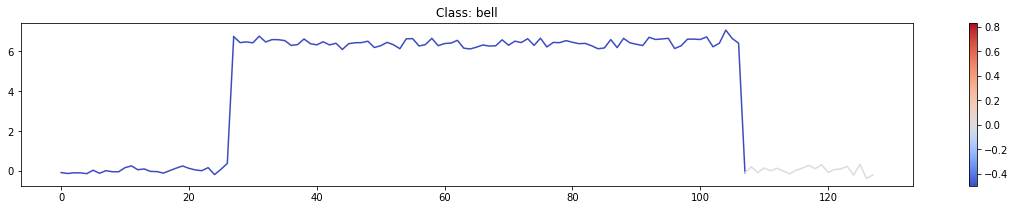

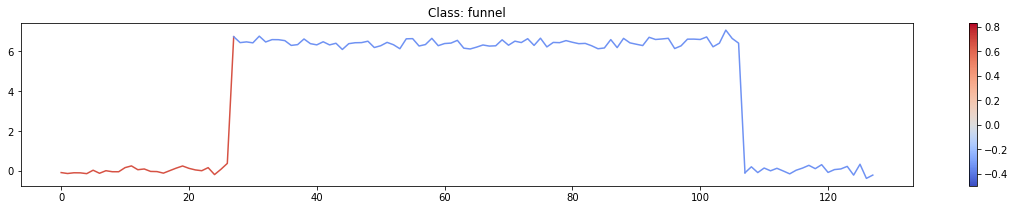

crule0


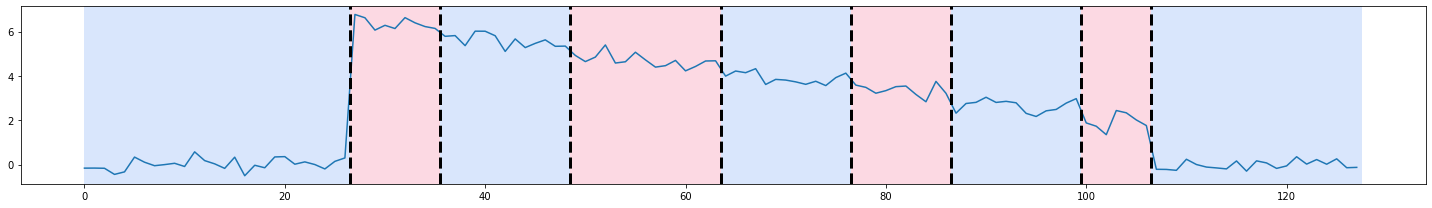

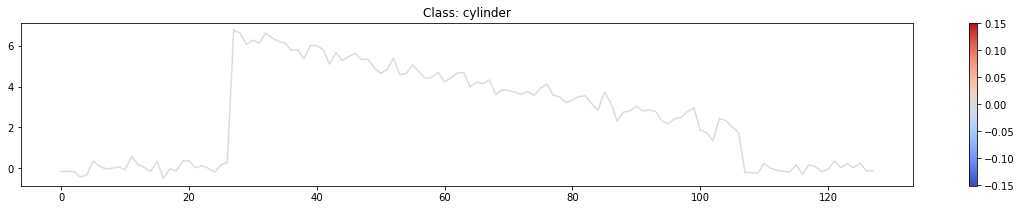

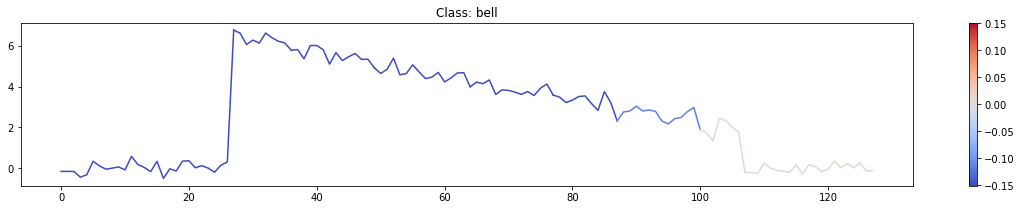

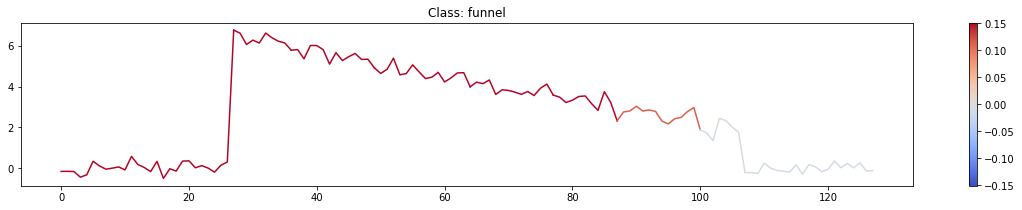



Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.2s finished


rule
Rules used to predict sample 0: 
sample predicted class:  cylinder
decision id node 0 : (shapelet n. 4 (distance = 7.5796967) > 2.0804061889648438)


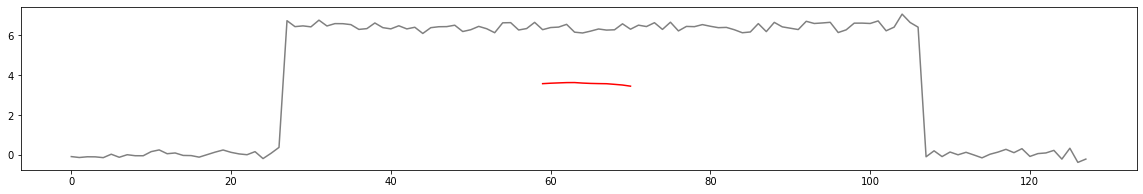

decision id node 0 : (shapelet n. 4 (distance = 7.5796967) > 2.0804061889648438)


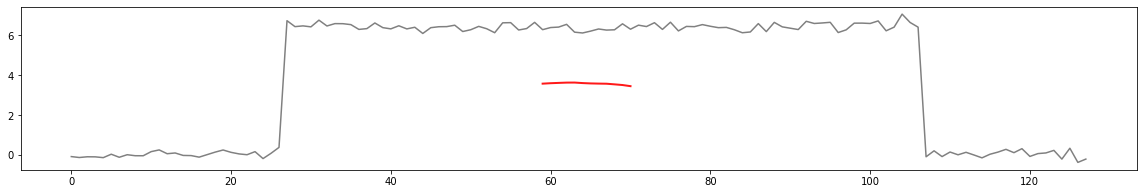

crule0
Rules used to predict sample 0: 
sample predicted class:  funnel
decision id node 0 : (shapelet n. 4 (distance = 0.049568176) <= 2.0804061889648438)
decision id node 1 : (shapelet n. 2 (distance = 1.6237743) <= 4.03644585609436)
decision id node 2 : (shapelet n. 0 (distance = 0.12958054) > 0.059098970144987106)
decision id node 6 : (shapelet n. 1 (distance = 0.09435527) <= 0.10371144860982895)
decision id node 7 : (shapelet n. 6 (distance = 0.7668772) <= 0.8726527094841003)


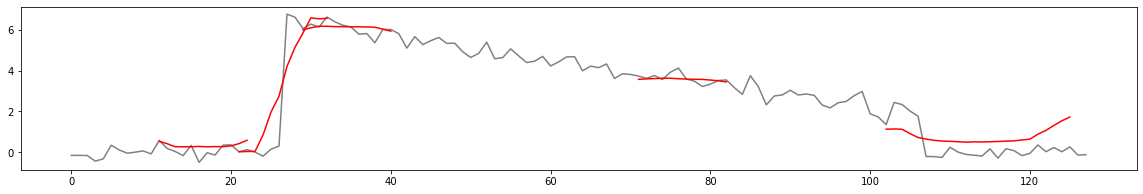

decision id node 0 : (shapelet n. 4 (distance = 0.049568176) <= 2.0804061889648438)


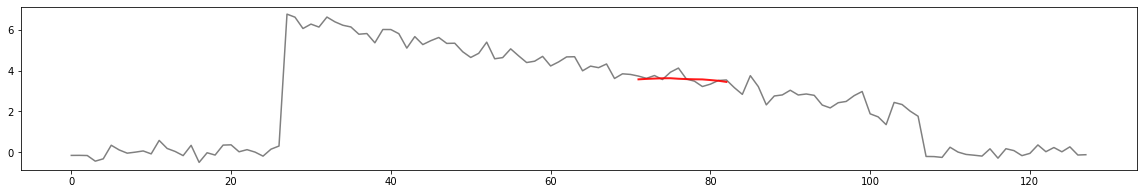

decision id node 1 : (shapelet n. 2 (distance = 1.6237743) <= 4.03644585609436)


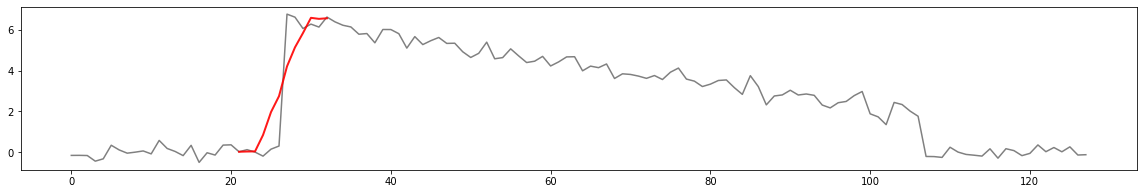

decision id node 2 : (shapelet n. 0 (distance = 0.12958054) > 0.059098970144987106)


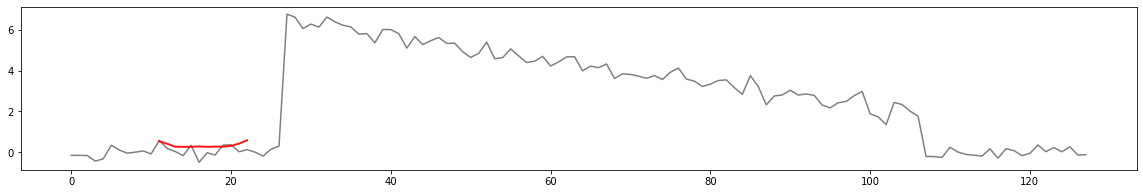

decision id node 6 : (shapelet n. 1 (distance = 0.09435527) <= 0.10371144860982895)


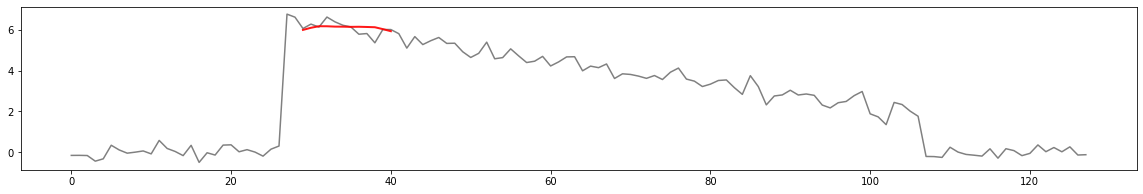

decision id node 7 : (shapelet n. 6 (distance = 0.7668772) <= 0.8726527094841003)


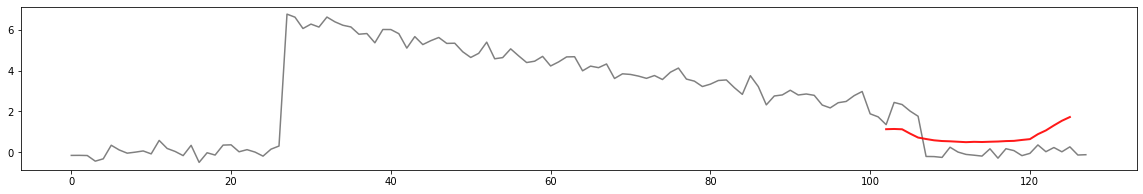

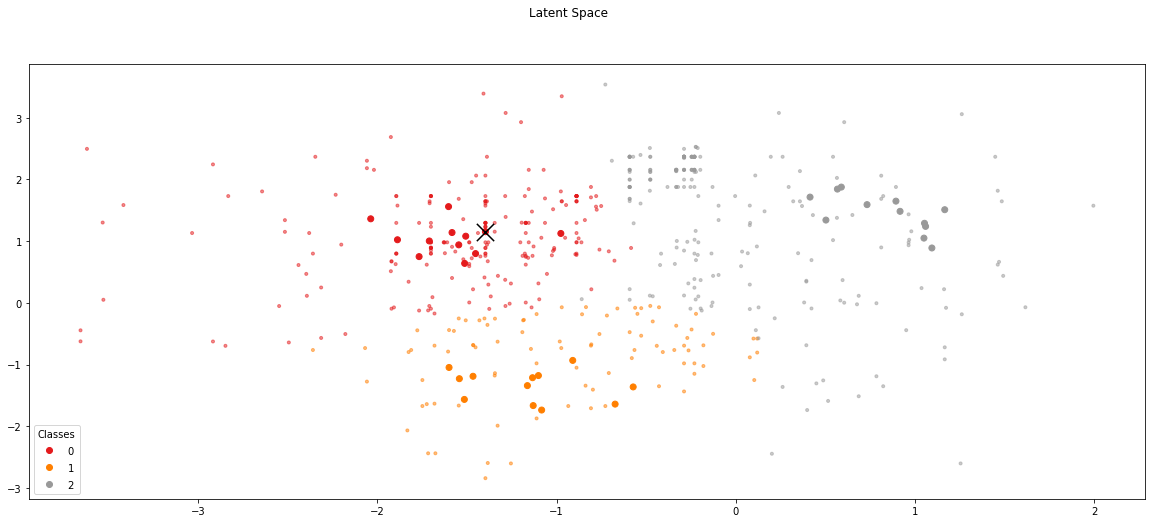

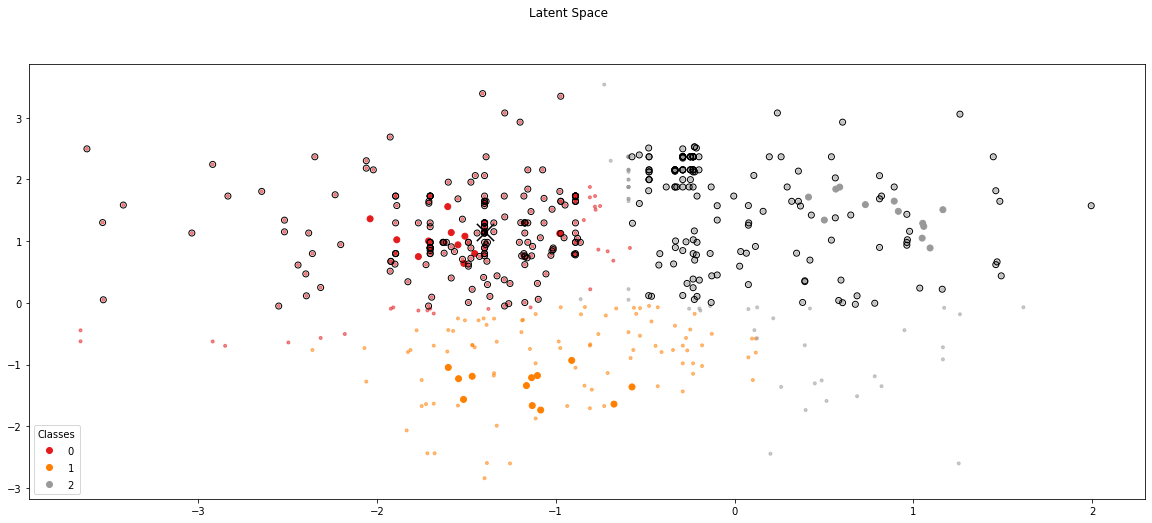

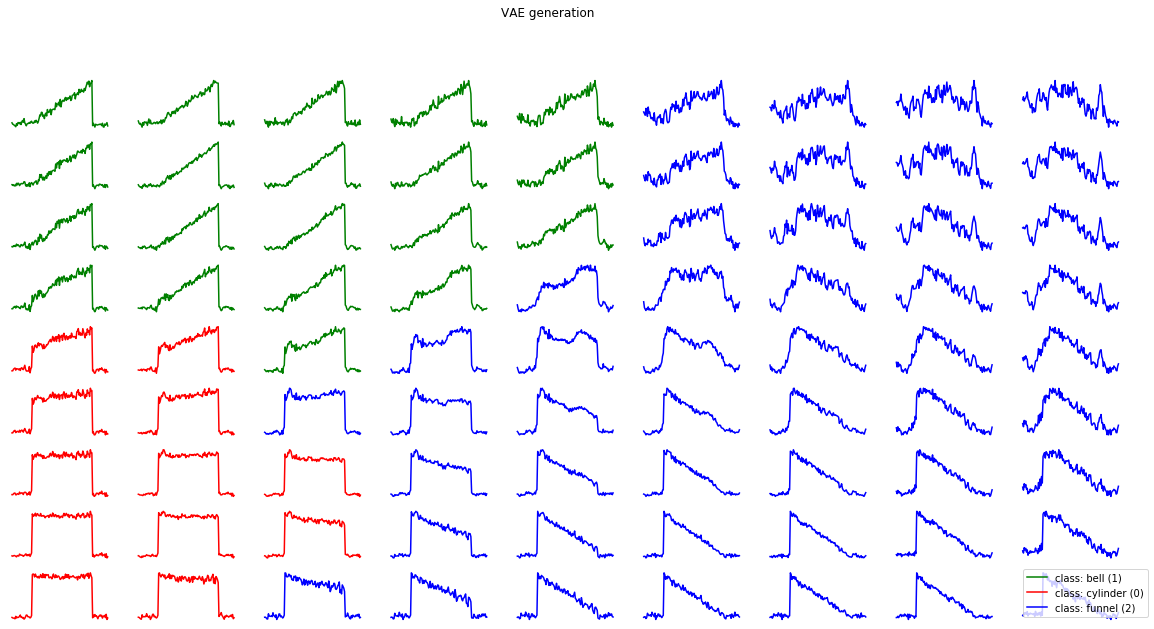

In [40]:
params = {"nsamples":1000, 
          "background":"linear_consecutive", 
          "pen":1, 
          "peltmodel":"l2",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3),
                          VAE_2d = True,
                          **params
                         )

## SIMPLECNN

In [41]:
blackbox = simplecnn

In [42]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [43]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [44]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.558537	0.00888121	0.993307
2  	103   	0.702896	0.0136096 	0.993307
3  	105   	0.80545 	0.0112183 	0.993307
4  	108   	0.884437	0.00691774	0.993307
5  	104   	0.870177	0.00674321	0.993307
6  	112   	0.883192	0.049904  	0.993307
7  	105   	0.879865	0.0101481 	0.993307
8  	103   	0.884957	0.00675446	0.993307
9  	111   	0.838028	0.00914155	0.993307
10 	103   	0.896088	0.00738018	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.554909	0.494375	0.993245
2  	108   	0.616836	0.493859	0.993245
3  	113   	0.728553	0.489338	0.993245
4  	110   	0.785208	0.495871	0.993282
5  	103   	0.872205	0.491927	0.993139
6  	105   	0.867133	0.496059	0.993298
7  	113   	0.914597	0.492388	0.993304
8  	102   	0.899978	0.496016	0.993304
9  	103   	0.882437	0.492092	0.993304
10 	111   	0.898329	0.494268	0.993307
synthetic neighborhood class counts {0: 218, 1: 124, 2: 181}


In [45]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [46]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


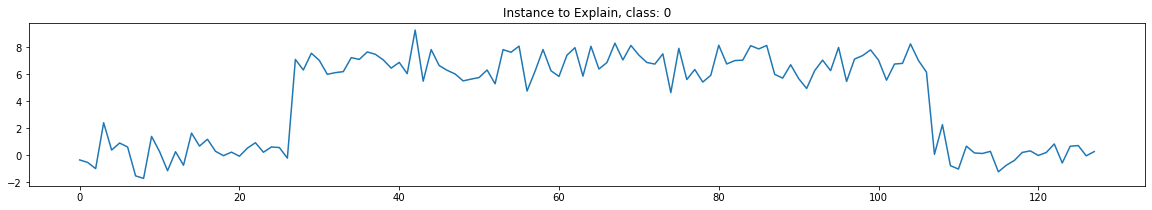

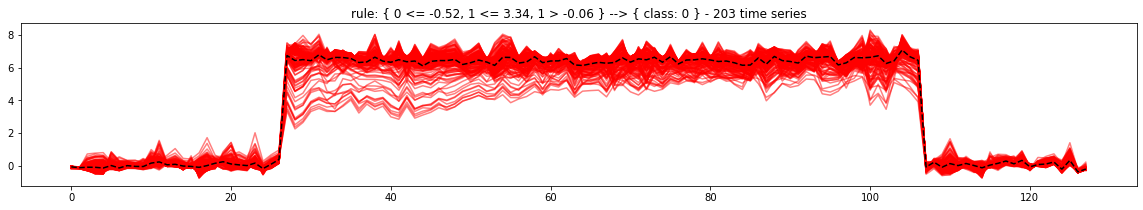

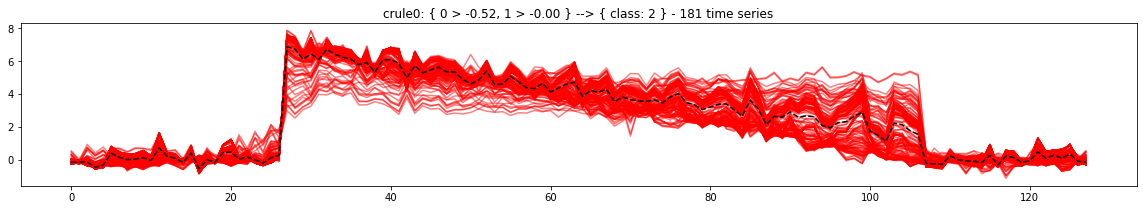

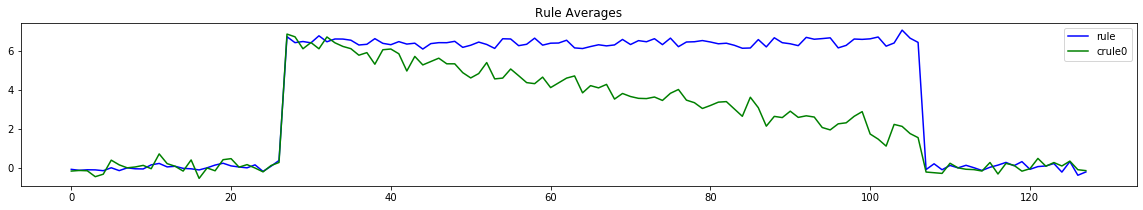

rule


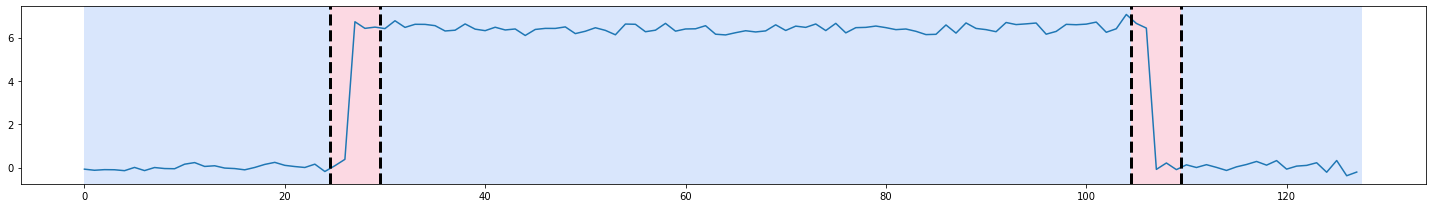

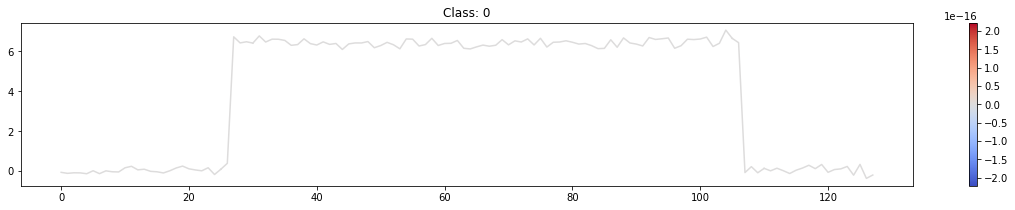

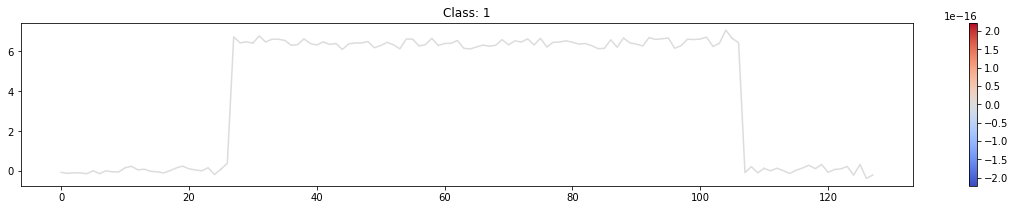

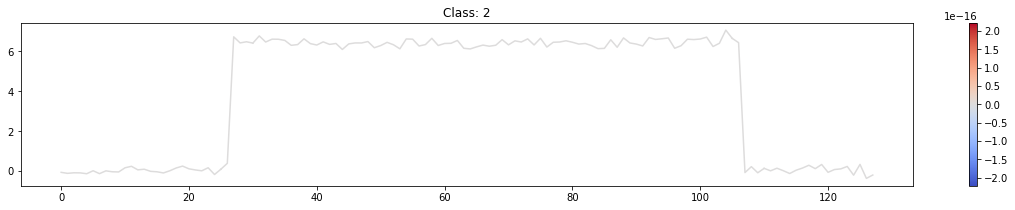

crule0


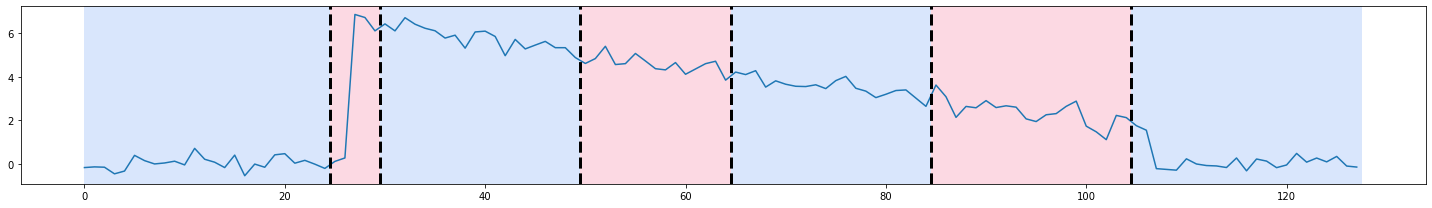

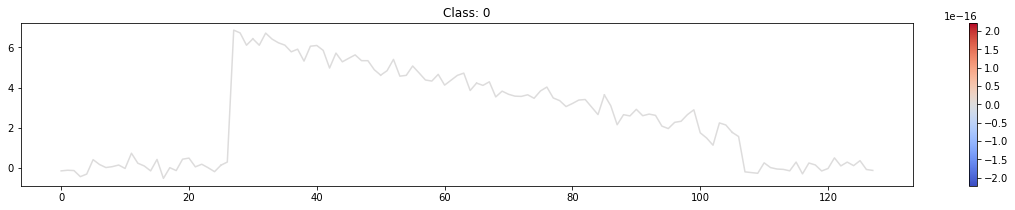

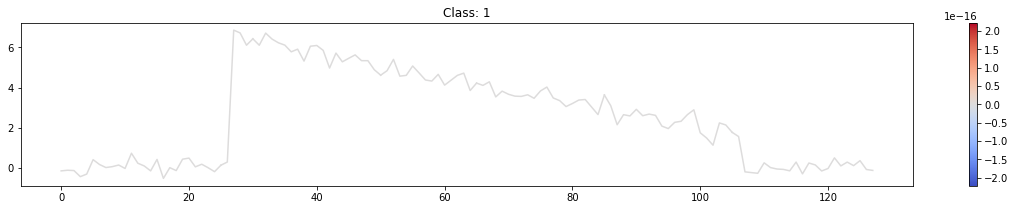

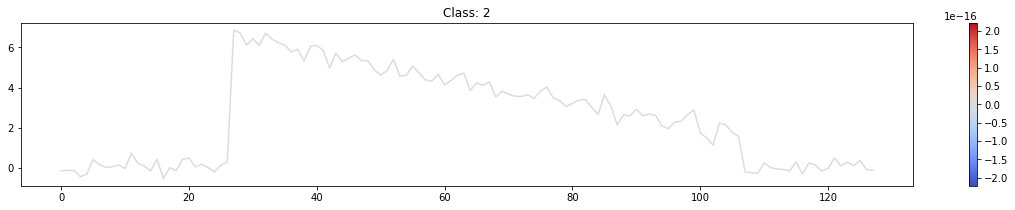

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.9s finished


rule
Rules used to predict sample 0: 
sample predicted class:  0
decision id node 0 : (shapelet n. 3 (distance = 6.712127) > 3.1522395610809326)


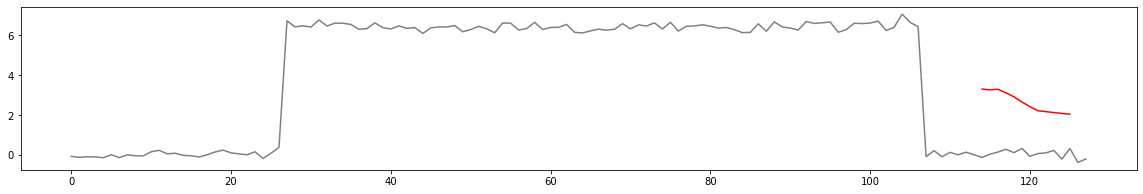

decision id node 0 : (shapelet n. 3 (distance = 6.712127) > 3.1522395610809326)


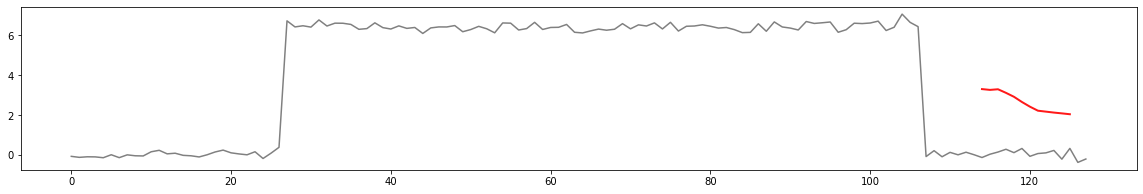

crule0
Rules used to predict sample 0: 
sample predicted class:  2
decision id node 0 : (shapelet n. 3 (distance = 0.19686127) <= 3.1522395610809326)
decision id node 1 : (shapelet n. 5 (distance = 2.1380973) <= 2.909890651702881)
decision id node 2 : (shapelet n. 0 (distance = 0.07516999) > 0.057257670909166336)
decision id node 20 : (shapelet n. 7 (distance = 0.36531067) <= 1.941571593284607)
decision id node 21 : (shapelet n. 9 (distance = 0.16044363) <= 1.767120361328125)
decision id node 22 : (shapelet n. 4 (distance = 2.245153) <= 3.319955825805664)


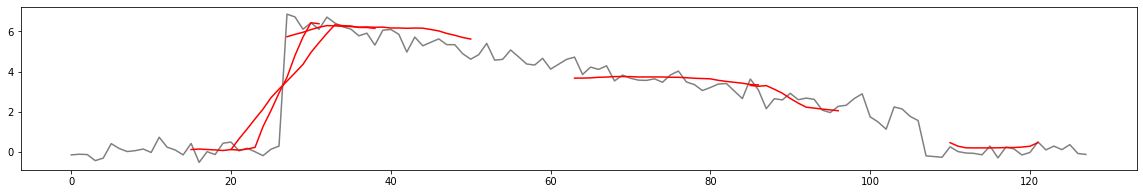

decision id node 0 : (shapelet n. 3 (distance = 0.19686127) <= 3.1522395610809326)


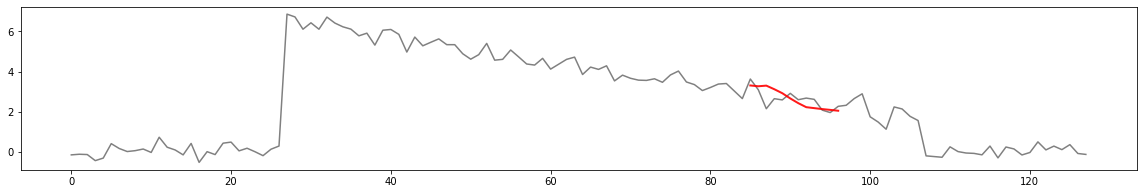

decision id node 1 : (shapelet n. 5 (distance = 2.1380973) <= 2.909890651702881)


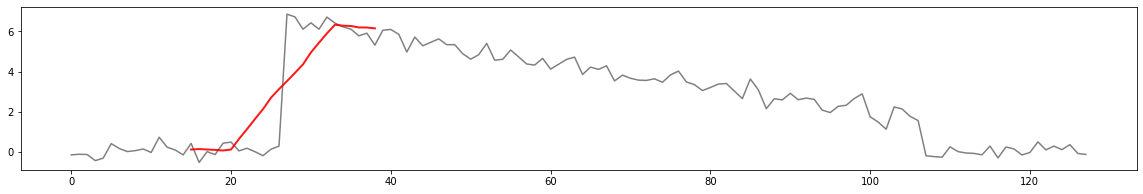

decision id node 2 : (shapelet n. 0 (distance = 0.07516999) > 0.057257670909166336)


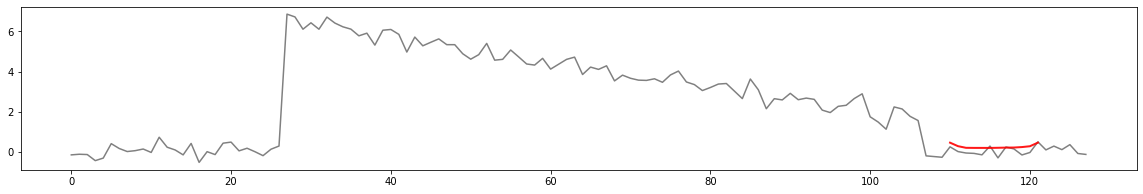

decision id node 20 : (shapelet n. 7 (distance = 0.36531067) <= 1.941571593284607)


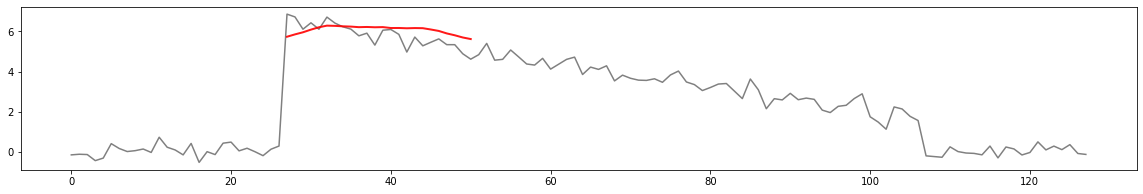

decision id node 21 : (shapelet n. 9 (distance = 0.16044363) <= 1.767120361328125)


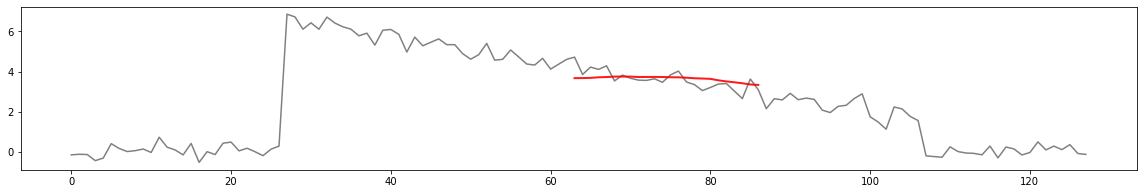

decision id node 22 : (shapelet n. 4 (distance = 2.245153) <= 3.319955825805664)


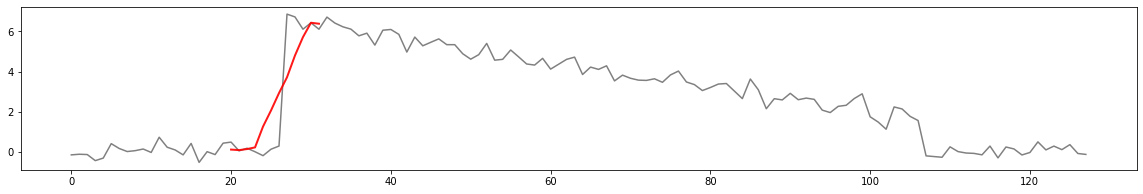

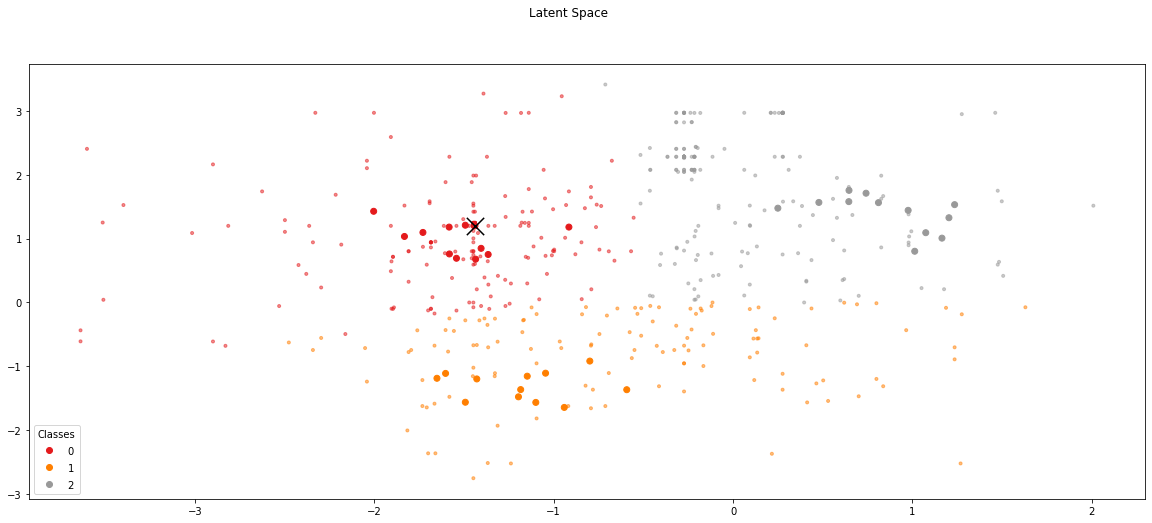

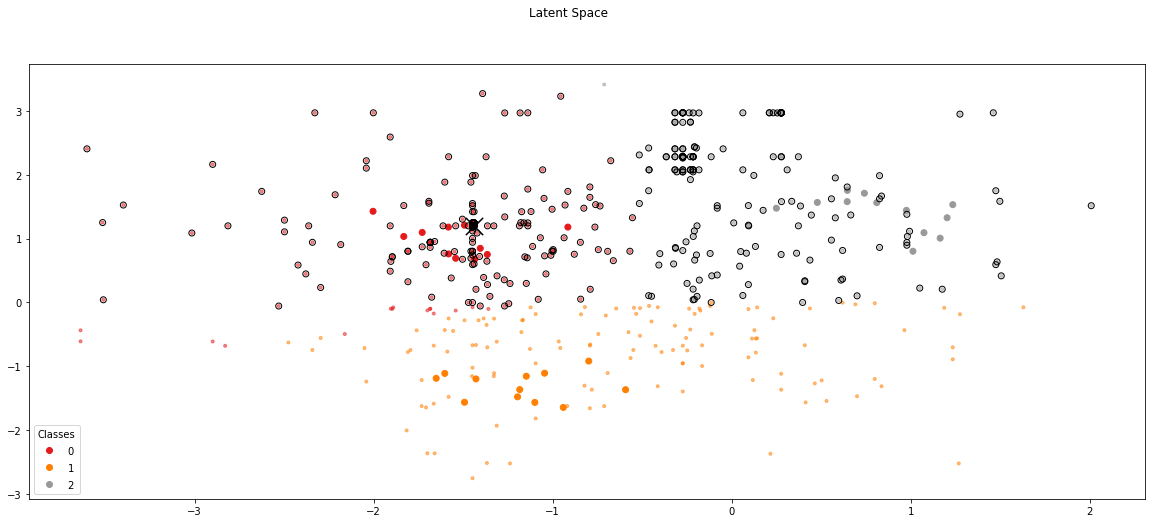

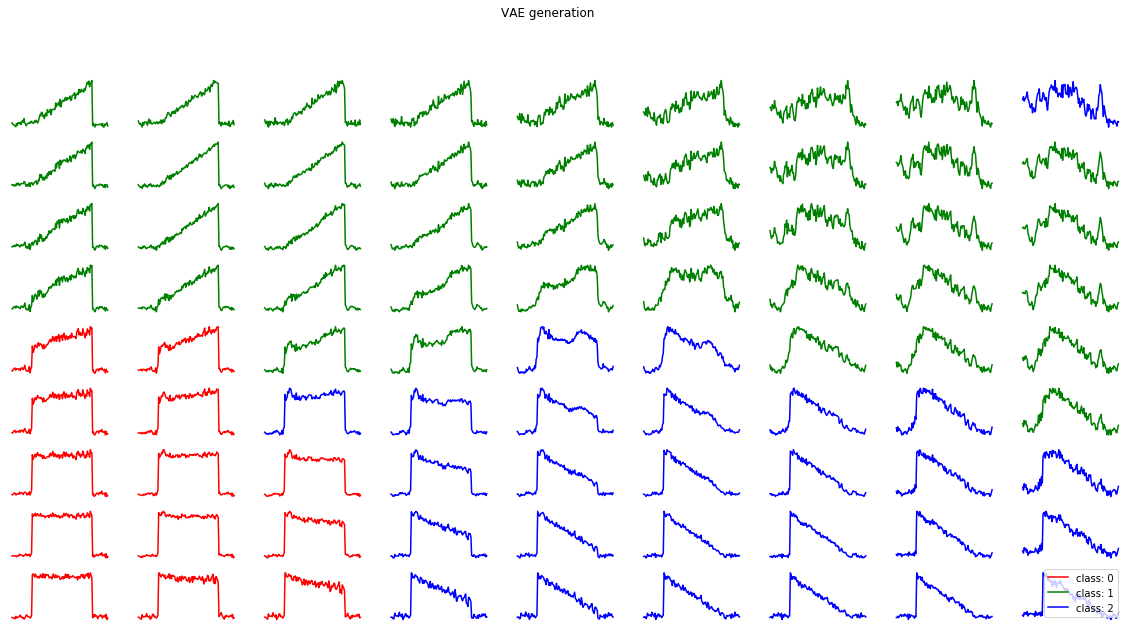

In [47]:
labels = ["cylinder", "bell", "funnel"]
shap_args = {"nsamples":100, "background": "adaptive_consecutive", "labels":labels, "pen":5}
shap_values = agnostic.plot_explanation( 
                         rules = True, 
                         heatmap = False, 
                         shap_args = shap_args, shapelet_explanation = True,
                         figsize = (20,3), class_label = labels[agnostic.instance_to_explain_class], VAE_2d = True
                         )

## KNN

In [48]:
blackbox = knn

In [49]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [50]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 2
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  0


In [51]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 500,
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)


calculating feature values
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	102   	0.555695	0.0107767	0.993305
2  	103   	0.704908	0.0159972	0.993306
3  	105   	0.803525	0.0129119	0.993307
4  	108   	0.885696	0.00679005	0.993307
5  	104   	0.876116	0.00692756	0.993307
6  	112   	0.87627 	0.0541685 	0.993307
7  	105   	0.901936	0.01142   	0.993307
8  	103   	0.888466	0.00672762	0.993307
9  	111   	0.839325	0.0101869 	0.993307
10 	103   	0.896643	0.00827944	0.993307
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	104   	0.563374	0.494128	0.993285
2  	108   	0.63169 	0.464767	0.993285
3  	113   	0.74622 	0.488723	0.993285
4  	110   	0.769215	0.496437	0.993285
5  	103   	0.866777	0.494549	0.993243
6  	105   	0.84979 	0.480835	0.993274
7  	113   	0.868181	0.485657	0.993289
8  	102   	0.870176	0.494977	0.993289
9  	103   	0.864889	0.492997	0.993289
10 	111   	0.88529 	0.494977	0.993305
synthetic neighborhood class counts {0: 215, 1: 138, 2: 170}


In [52]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [53]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


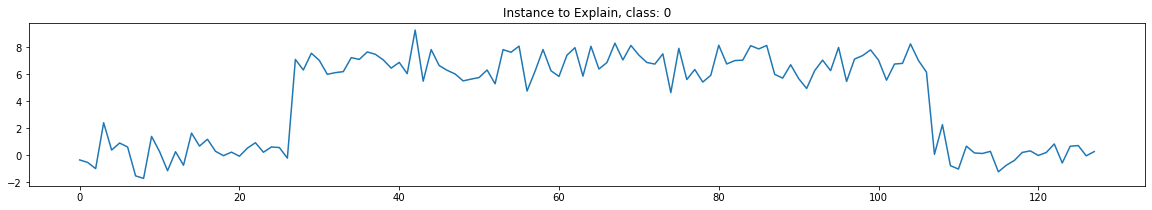

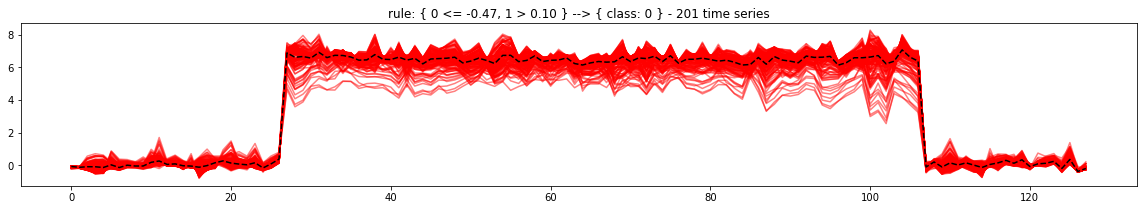

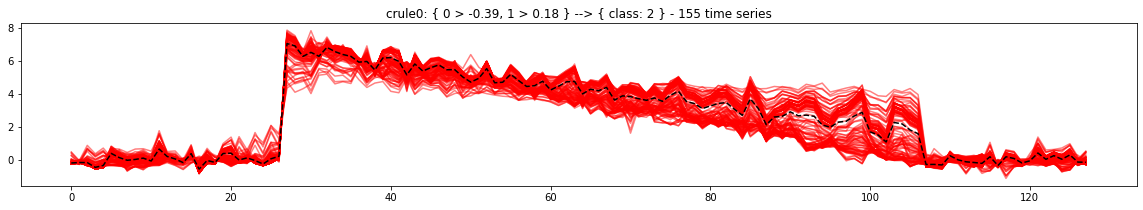

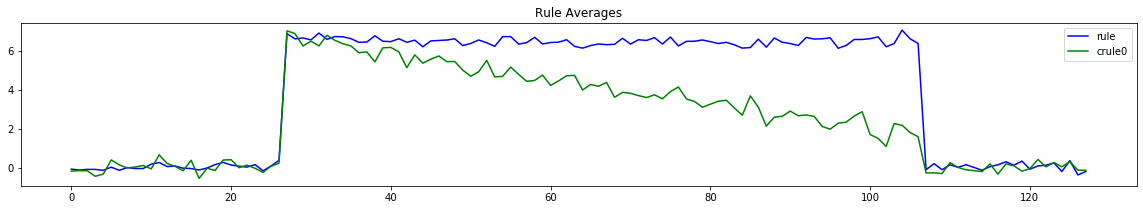

rule


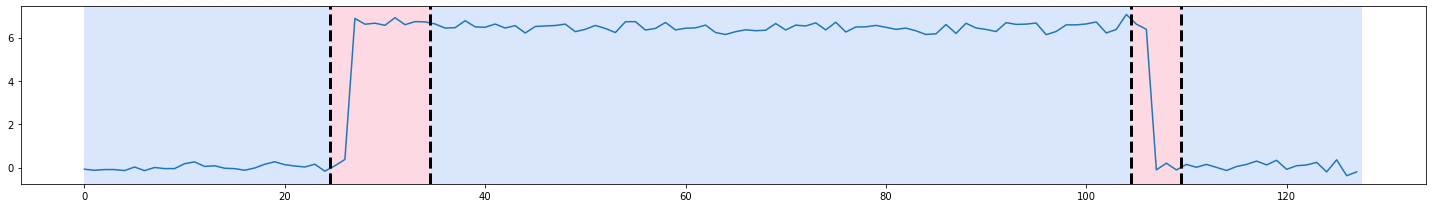

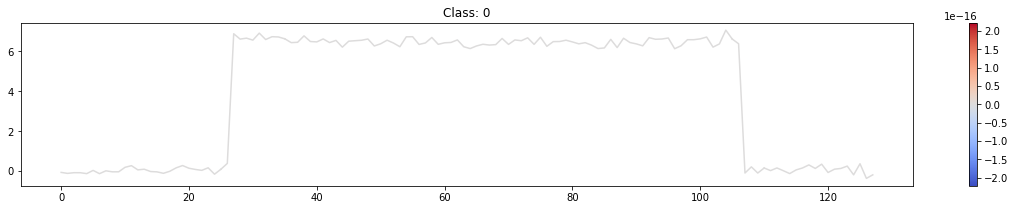

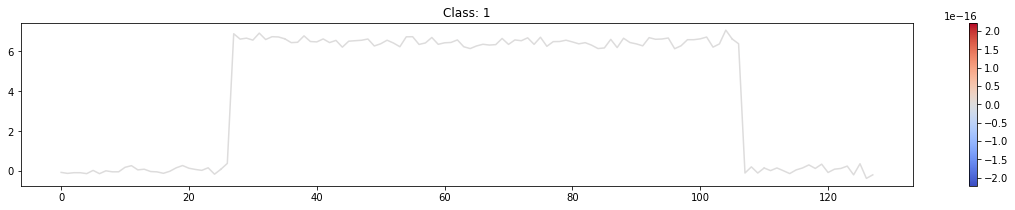

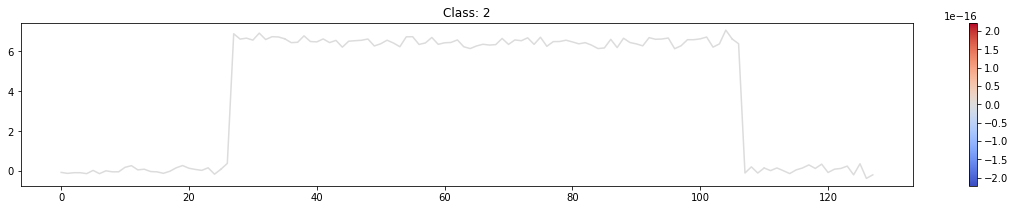

crule0


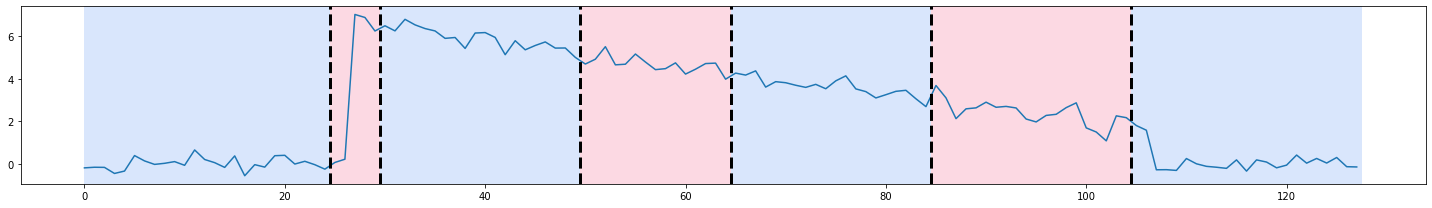

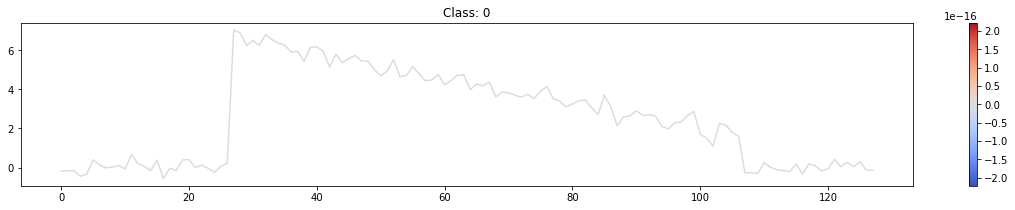

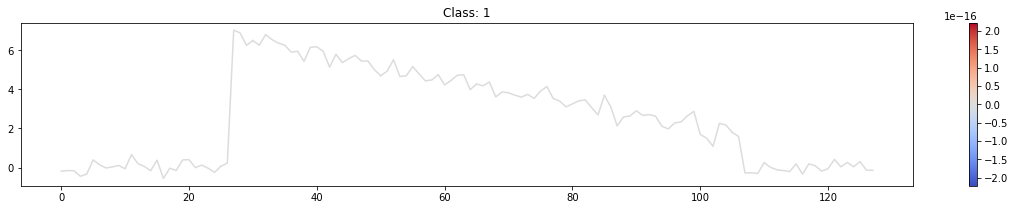

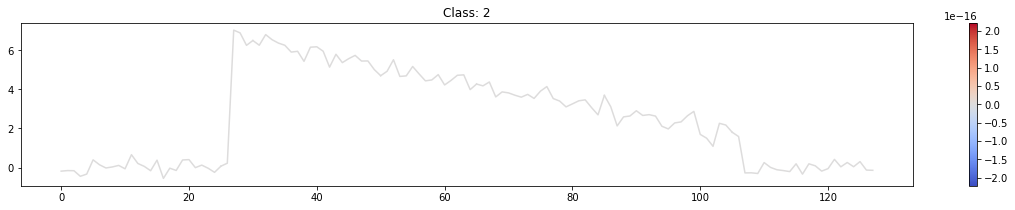

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.6s finished


rule
Rules used to predict sample 0: 
sample predicted class:  0
decision id node 0 : (shapelet n. 0 (distance = 8.061239) > 0.6415520012378693)
decision id node 18 : (shapelet n. 3 (distance = 2.078209) <= 3.142812132835388)


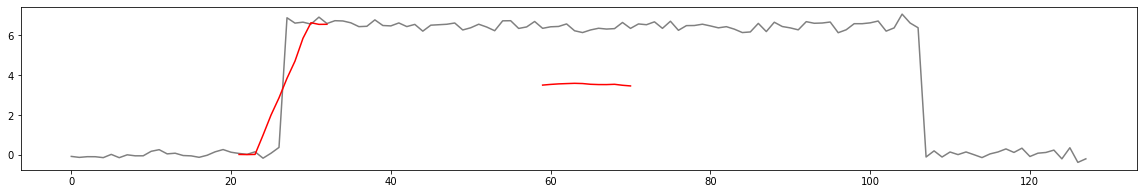

decision id node 0 : (shapelet n. 0 (distance = 8.061239) > 0.6415520012378693)


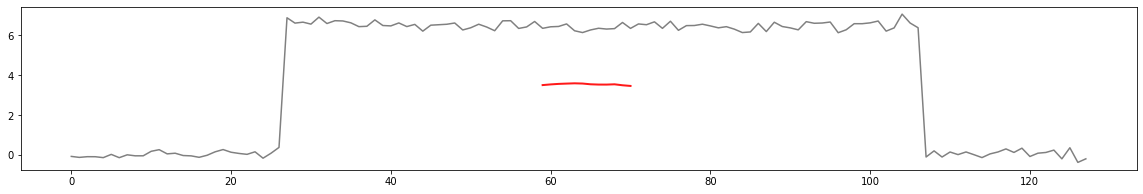

decision id node 18 : (shapelet n. 3 (distance = 2.078209) <= 3.142812132835388)


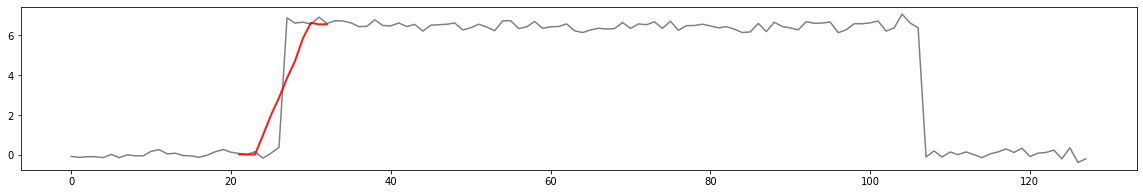

crule0
Rules used to predict sample 0: 
sample predicted class:  2
decision id node 0 : (shapelet n. 0 (distance = 0.064824425) <= 0.6415520012378693)
decision id node 1 : (shapelet n. 4 (distance = 5.064573) > 3.2903800010681152)
decision id node 13 : (shapelet n. 5 (distance = 2.157313) <= 2.841778516769409)
decision id node 14 : (shapelet n. 9 (distance = 0.19049582) <= 0.7007637321949005)


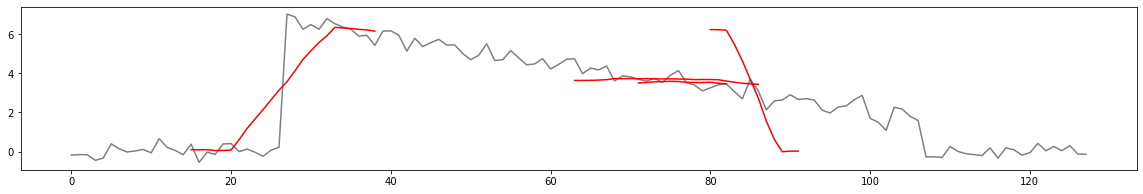

decision id node 0 : (shapelet n. 0 (distance = 0.064824425) <= 0.6415520012378693)


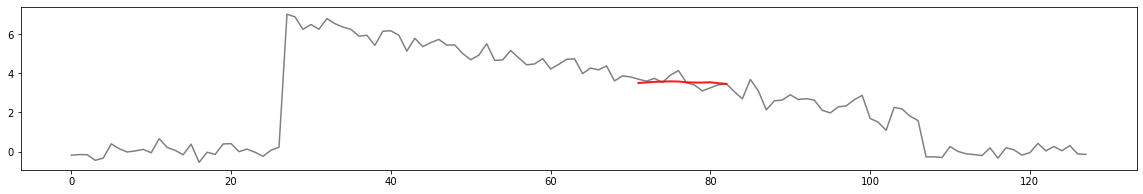

decision id node 1 : (shapelet n. 4 (distance = 5.064573) > 3.2903800010681152)


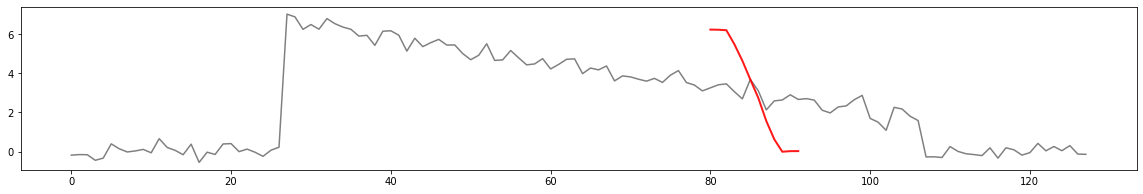

decision id node 13 : (shapelet n. 5 (distance = 2.157313) <= 2.841778516769409)


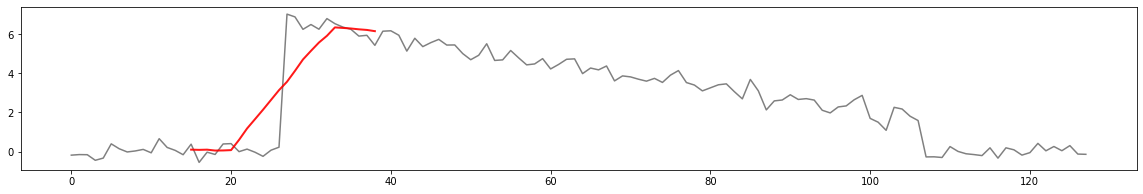

decision id node 14 : (shapelet n. 9 (distance = 0.19049582) <= 0.7007637321949005)


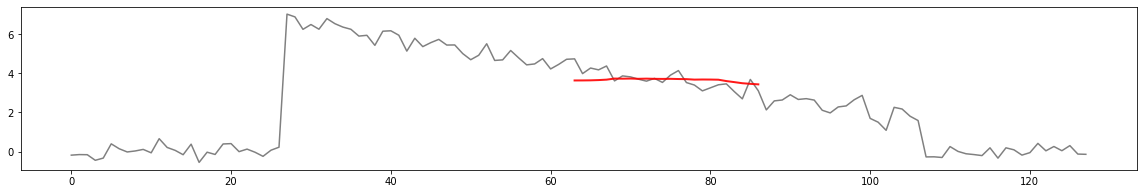

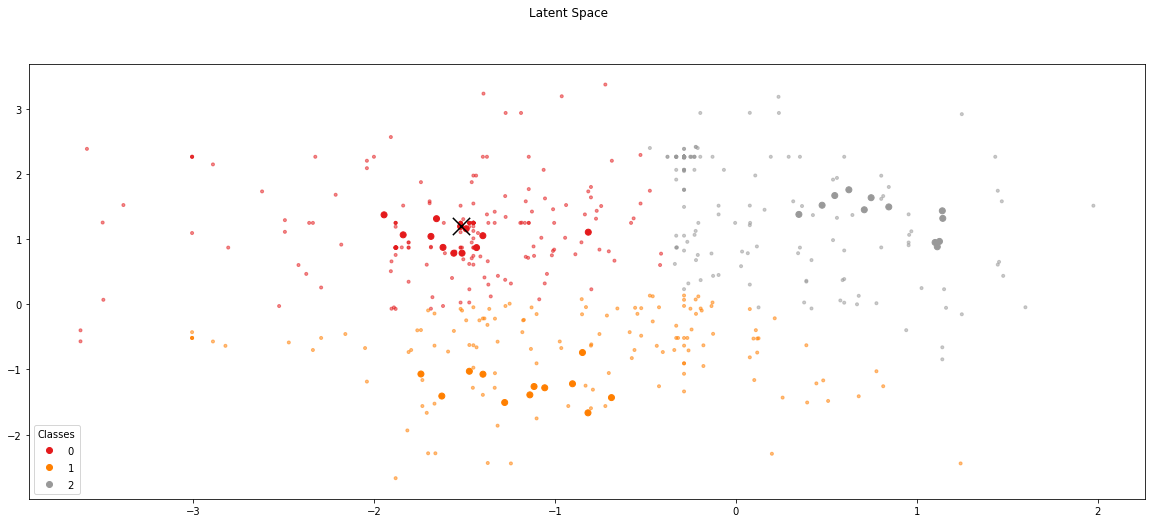

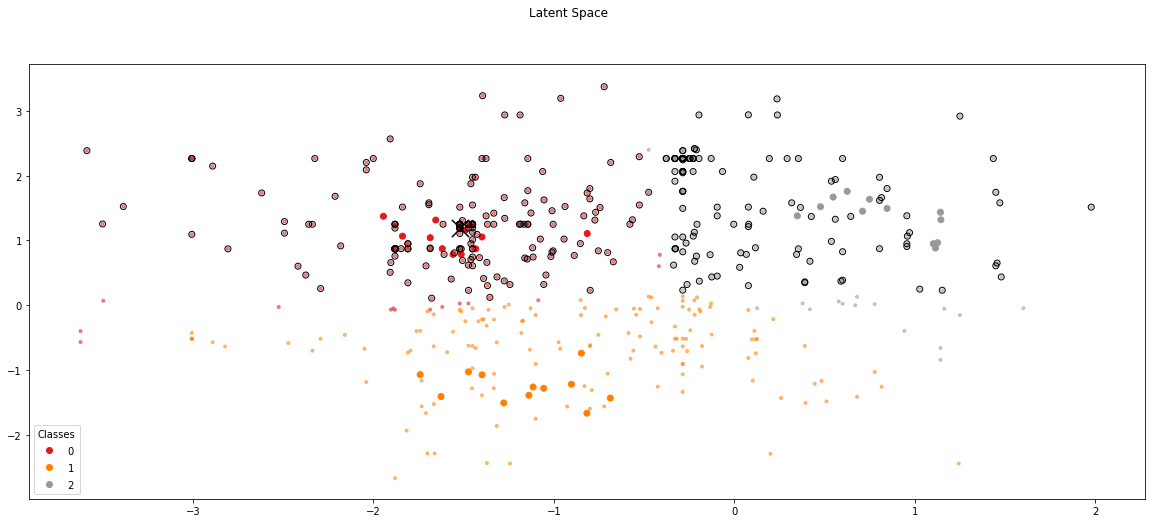

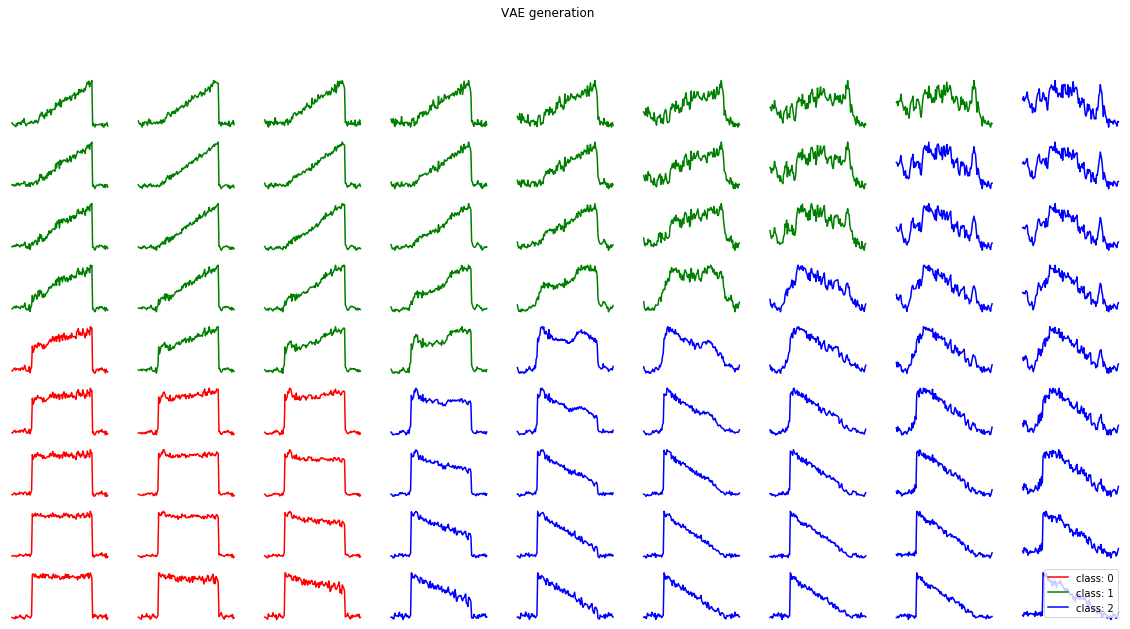

In [54]:
labels = ["cylinder", "bell", "funnel"]
shap_args = {"nsamples":100, "background": "adaptive_consecutive", "labels":labels, "pen":5}
shap_values = agnostic.plot_explanation( 
                         rules = True, 
                         heatmap = False, 
                         shap_args = shap_args, shapelet_explanation = True,
                         figsize = (20,3), class_label = labels[agnostic.instance_to_explain_class], VAE_2d = True
                         )